# MPA-MLF: Final project

Made by Dmitrii Semenov, Josef Pecka

Step 1: Import libraries

In [32]:
# Import general libraries
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Import main functions for ML
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split


# Import Tuner
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

# Import confusion matrix fucntion
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set plot font 
font = {'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

Step 2: Load input files

In [56]:
# Set dataset paths
dataset_dir = ""
train_dir = os.path.join(dataset_dir, "Train")
test_dir = os.path.join(dataset_dir, "Test")
labels_path = os.path.join(dataset_dir, "label_train.csv")
test_format_path = os.path.join(dataset_dir, "test_format.csv")

# Load labels file
labels_df = pd.read_csv(labels_path)

# Prepare containers
X = []
y = []

# Loop through each file ID
for _, row in labels_df.iterrows():
    file_name = f"{row['ID']}.npy"
    file_path = os.path.join(train_dir, file_name)
    try:
        sample = np.load(file_path)
        X.append(sample)
        y.append(row['target'])
    except Exception as e:
        print(f"[Error] Could not load {file_name}: {e}")

# Convert to NumPy arrays
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int32)

print(f"[INFO] Loaded {X.shape[0]} samples of shape {X.shape[1:]}")
print(f"[INFO] Max value of X data {np.max(X)}")
print(f"[INFO] Min value of X data {np.min(X)}")


[INFO] Loaded 1491 samples of shape (72, 48)
[INFO] Max value of X data 76.52984619140625
[INFO] Min value of X data -66.49512481689453


Step 3: Data preprocessing

In [57]:
# Z-score normalization
X = X.astype("float32")
X_mean = X.mean()
X_std = X.std()
X = (X - X_mean) / X_std

print(f"[INFO] Mean value of data after Z-score normalizations: {np.mean(X)}")

# Reshape for CNN input
X = X.reshape((-1, 72, 48, 1))

# One-hot encode labels
NUM_CLASSES = 3
y = to_categorical(y, NUM_CLASSES)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y,
    test_size=0.2,
    stratify=y.argmax(axis=1),
    random_state=42
)

# Print result
print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}, y_val shape: {y_val.shape}")

[INFO] Mean value of data after Z-score normalizations: -4.2031363278738354e-08
X_train shape: (1192, 72, 48, 1), X_val shape: (299, 72, 48, 1)
y_train shape: (1192, 3), y_val shape: (299, 3)


Visualize class distribution in training and validation sets

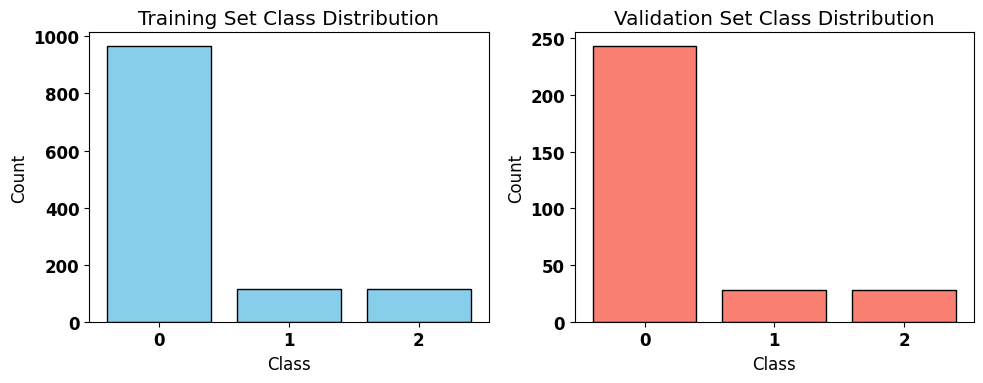

In [59]:
# Convert one-hot labels back to class indices
y_train_labels = y_train.argmax(axis=1)
y_val_labels = y_val.argmax(axis=1)

# Plot
plt.figure(figsize=(10, 4))

# Training set
plt.subplot(1, 2, 1)
plt.hist(y_train_labels, bins=np.arange(NUM_CLASSES + 1) - 0.5, rwidth=0.8, color='skyblue', edgecolor='black')
plt.xticks(range(NUM_CLASSES))
plt.title("Training Set Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")

# Validation set
plt.subplot(1, 2, 2)
plt.hist(y_val_labels, bins=np.arange(NUM_CLASSES + 1) - 0.5, rwidth=0.8, color='salmon', edgecolor='black')
plt.xticks(range(NUM_CLASSES))
plt.title("Validation Set Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

Step 4: CNN model definition + Keras Tuner